In [1]:
# basics
import numpy as np
import pandas as pd
import datetime
import re
import os,glob
import pickle
import textwrap

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);
import crossvalidationclass as cvc; reload(cvc);

np.seterr(divide = 'ignore');

default_params   = {'ExternalObservableFile': 'COVID19_data_PAPER_VERSION.csv',
                    'datasourceinfo':{'DatafileName':'COVID19_non-pharmaceutical-interventions_PAPER_VERSION.csv'},
                    'resolve_US_states': True,
                    'FinalDateFile': 'CCCSL_enddates.csv',
                    'FinalDateFileDateFormat': '%Y-%m-%d',
                    'FinalDateExtendWithShiftdays':True}


In [2]:
crossval = cvc.CrossValidation()

In [3]:
mainresults = pd.read_csv('comparison_of_rankings - Main_results.csv')

score_results = pd.read_csv('comparison_of_rankings - L2 Scores.csv')
score_measurenames = np.array(list(score_results['NPI'].str.split('--')))
score_results['L1 theme'] = [x.strip(' \'') for x in score_measurenames[:,0]]
score_results['L2 category'] = [x.strip(' \'') for x in score_measurenames[:,1]]

mainresults = mainresults.merge(score_results,left_on = ['L1 theme','L2 category'], right_on = ['L1 theme','L2 category'])

zscores_results = pd.read_csv('comparison_of_rankings - Data for Heatmap.csv', skiprows=1)
zscores_measurenames = np.array(list(zscores_results['NPI'].str.split('--')))
zscores_results['L1 theme'] = [x.strip(' \'') for x in zscores_measurenames[:,0]]
zscores_results['L2 category'] = [x.strip(' \'') for x in zscores_measurenames[:,1]]
zscores_results.fillna(0,inplace = True)

mainresults = mainresults.merge(zscores_results,left_on = ['L1 theme','L2 category'], right_on = ['L1 theme','L2 category'])

mainresults['CC_low']   = mainresults['Delta_CC']  - mainresults['95%CI_Delta_CC']
mainresults['RF_low']   = mainresults['Delta_RF']  - mainresults['95%CI_Delta_RF']
mainresults['RNN_low']  = mainresults['Delta_RNN'] - mainresults['95%CI_Delta_RNN']

mainresults['CC_high']  = mainresults['Delta_CC']  + mainresults['95%CI_Delta_CC']
mainresults['RF_high']  = mainresults['Delta_RF']  + mainresults['95%CI_Delta_RF']
mainresults['RNN_high'] = mainresults['Delta_RNN'] + mainresults['95%CI_Delta_RNN']

mainresults['SCORE_low'] = mainresults['Normalized Score']
mainresults['SCORE_high'] = mainresults['Normalized Score']

mainresults.rename({'LASSO_median':'LASSO_DeltaR','LASSO_low95':'LASSO_low','LASSO_high95':'LASSO_high','Delta_CC':'CC_DeltaR','Delta_RF':'RF_DeltaR','Delta_RNN':'RNN_DeltaR','Normalized Score':'SCORE_DeltaR'}, axis = 'columns', inplace = True)
mainresults.head()

,L1 theme,L2 category,Countries with Implementation,RF_DeltaR,95%CI_Delta_RF,CC_DeltaR,95%CI_Delta_CC,Rank_RNN,RNN_DeltaR,95%CI_Delta_RNN,...,RNN.3,LASSO.3,CC_low,RF_low,RNN_low,CC_high,RF_high,RNN_high,SCORE_low,SCORE_high
0,"Case identification, contact tracing and relat...",Activate case notification,18,0.002097,0.001364,0.0,0.0,51,0.0633,0.0021,...,0.00,0.0,0.0,0.000733,0.0612,0.0,0.003461,0.0654,0.108589,0.108589
1,"Case identification, contact tracing and relat...",Airport health check,52,0.003804,0.001559,0.0,0.0,50,0.0502,0.0010,...,0.00,0.0,0.0,0.002245,0.0492,0.0,0.005364,0.0512,0.084722,0.084722
2,"Case identification, contact tracing and relat...",Border health check,24,0.001305,0.001344,0.0,0.0,4,-0.0875,0.0027,...,42.39,0.0,0.0,-0.000040,-0.0902,0.0,0.002649,-0.0848,0.238172,0.238172
3,"Case identification, contact tracing and relat...",Enhance detection system,24,0.000221,0.001726,0.0,0.0,49,0.0443,0.0015,...,15.32,0.0,0.0,-0.001505,0.0428,0.0,0.001948,0.0458,0.047804,0.047804
4,"Case identification, contact tracing and relat...",Isolation of cases,17,0.001270,0.001445,0.0,0.0,40,0.0114,0.0011,...,0.00,0.0,0.0,-0.000175,0.0103,0.0,0.002714,0.0125,0.137811,0.137811


In [6]:
L1colors = crossval.L1colors

def PlotMeasureListSorted(measure_effects = None, plot_keys = [], filename = 'measurelist_sorted.pdf', drop_zeros = False, figsize = (15,30), labelsize = 40, blacklines = [0], graylines = [-30,-20,-10,10], border = 2, title = '', textbreak = 40, include_countries = False, rescale = False, entryheight = None, sort_ascending = True, observable = r'$\Delta R_t$', observable_text_pos = [0,2]):
    # get plotting area
    minplot      = np.min(blacklines + graylines)
    maxplot      = np.max(blacklines + graylines)

    # function to plot one row in DF
    def PlotRow(ax, ypos = 1, values = None, color = '#ffffff', boxalpha = .4, textbreak = 40):
        ax.plot(values[plot_keys[0]],[ypos], c = color, marker = 'D')
        ax.plot([values[plot_keys[1]],values[plot_keys[2]]],[ypos,ypos], c = color, lw = 2)
        background = plt.Rectangle([1e-2 * (minplot - border - 2 * labelsize), ypos - .4], 1e-2*(2*labelsize + maxplot + border - minplot), .9, fill = True, fc = color, alpha = boxalpha, zorder = 1)
        ax.add_patch(background)
        ax.annotate(textwrap.shorten(values['L1 theme'],    width = textbreak), [1e-2*(minplot - 2 * labelsize), ypos - .1], zorder = 5)
        ax.annotate(textwrap.shorten(values['L2 category'], width = textbreak), [1e-2*(minplot - 1 * labelsize), ypos - .1], zorder = 5)
    
    me_local = measure_effects[(measure_effects[plot_keys[0]]!=0) | (measure_effects[plot_keys[1]]!=0) | (measure_effects[plot_keys[2]]!=0)]
    me_local.sort_values(by = plot_keys, ascending = sort_ascending, inplace = True)
                 
    # actual plotting including vertical lines
    if not entryheight is None:
        figsize = (figsize[0],(len(me_local) + 4.5) * entryheight)
    fig, ax = plt.subplots(1,1,figsize = figsize)

    for j,(index,values) in enumerate(me_local.iterrows()):
        PlotRow(ax, ypos = -j,values = values, color = L1colors[values['L1 theme']], textbreak = textbreak)
    for x in blacklines:
        ax.plot([1e-2 * x,1e-2 * x],[0.7,-j-0.5], lw = 2, c = 'black',zorder = -2)
        ax.annotate('{:.2f}'.format(x * 1e-2),[1e-2*x,0.9],fontsize = 12, c = 'gray', ha = 'center')
    for x in graylines:
        ax.plot([1e-2 * x,1e-2 * x],[0.6,-j-0.4], lw = 1, c = 'gray',zorder = -2)
        ax.annotate('{:.2f}'.format(x * 1e-2),[1e-2*x,0.9],fontsize = 12, c = 'gray', ha = 'center')

    # format output
    if title != '':
        ax.annotate(title,[1e-2 * (-2*labelsize + minplot),2], fontsize = 12, weight = 'bold')
    ax.annotate('L1 Theme',[1e-2 * (-2*labelsize + minplot), 1], weight = 'bold', fontsize = 12)
    ax.annotate('L2 Category', [1e-2 * (-labelsize + minplot), 1], weight = 'bold', fontsize = 12)
    ax.annotate(observable,observable_text_pos, fontsize = 12, weight = 'bold')
    ax.set_xlim([1e-2 * (-2 * labelsize - 2*border + minplot), 1e-2 * (maxplot+border)])
    ax.set_ylim([-j-2,2.5])
    ax.axis('off')

    fig.tight_layout()
    fig.savefig(filename, bbox_inches = 'tight')



/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


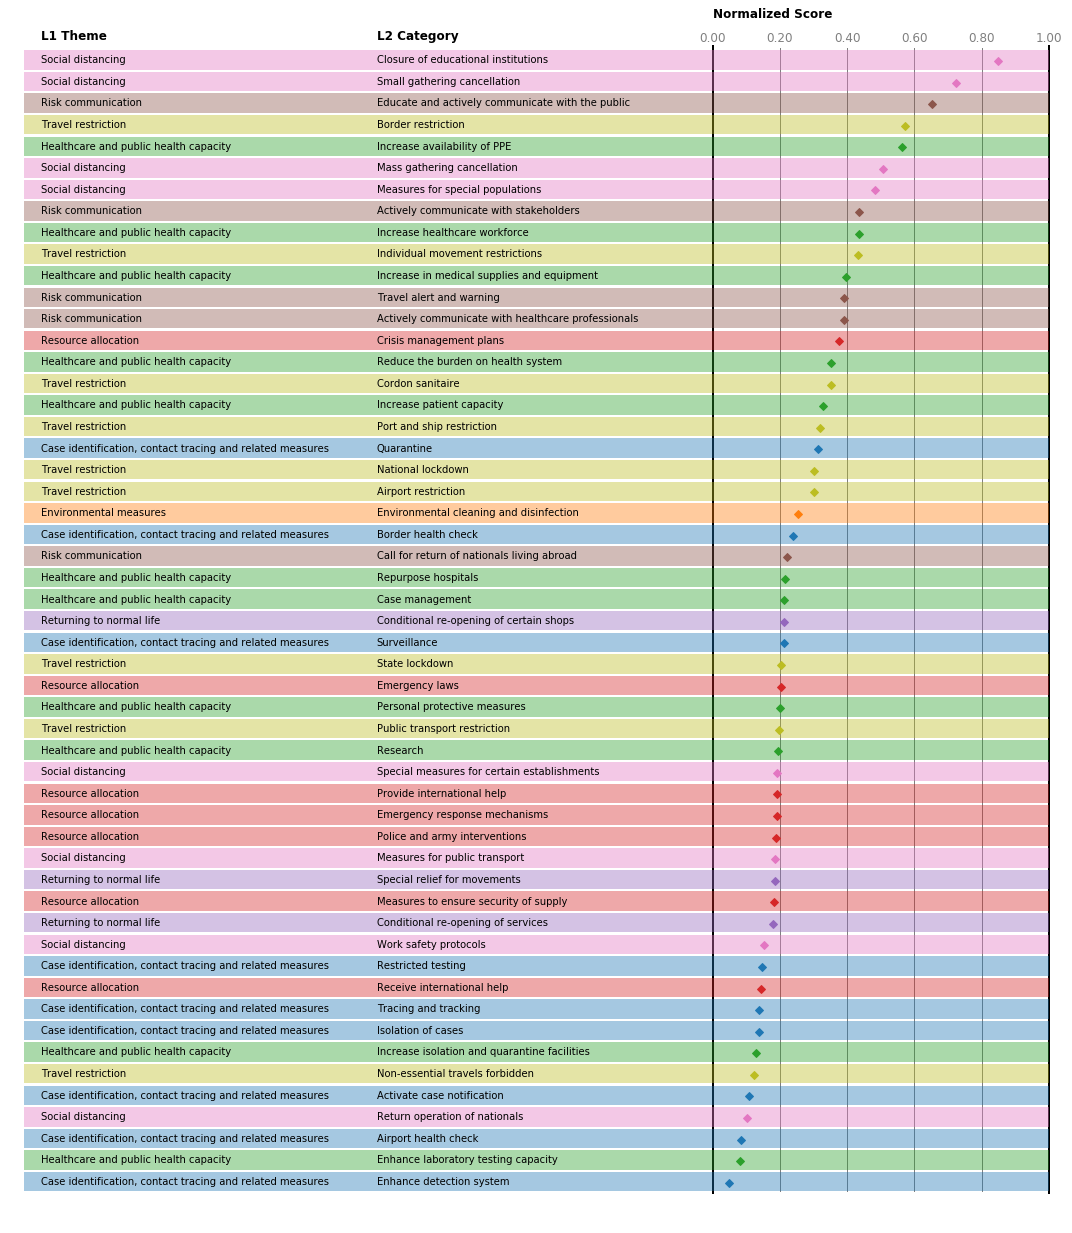

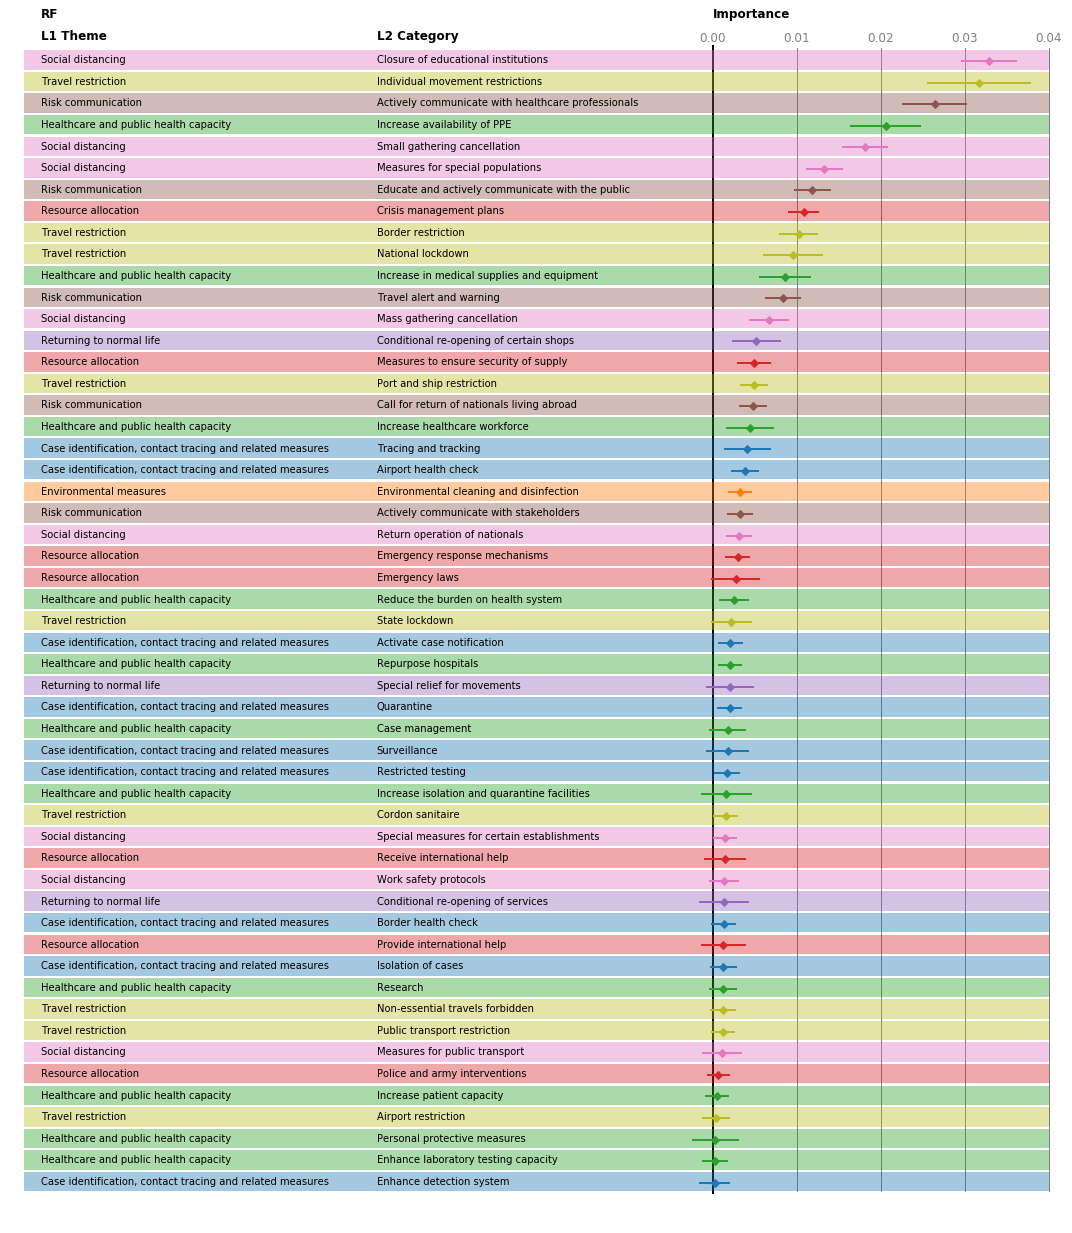

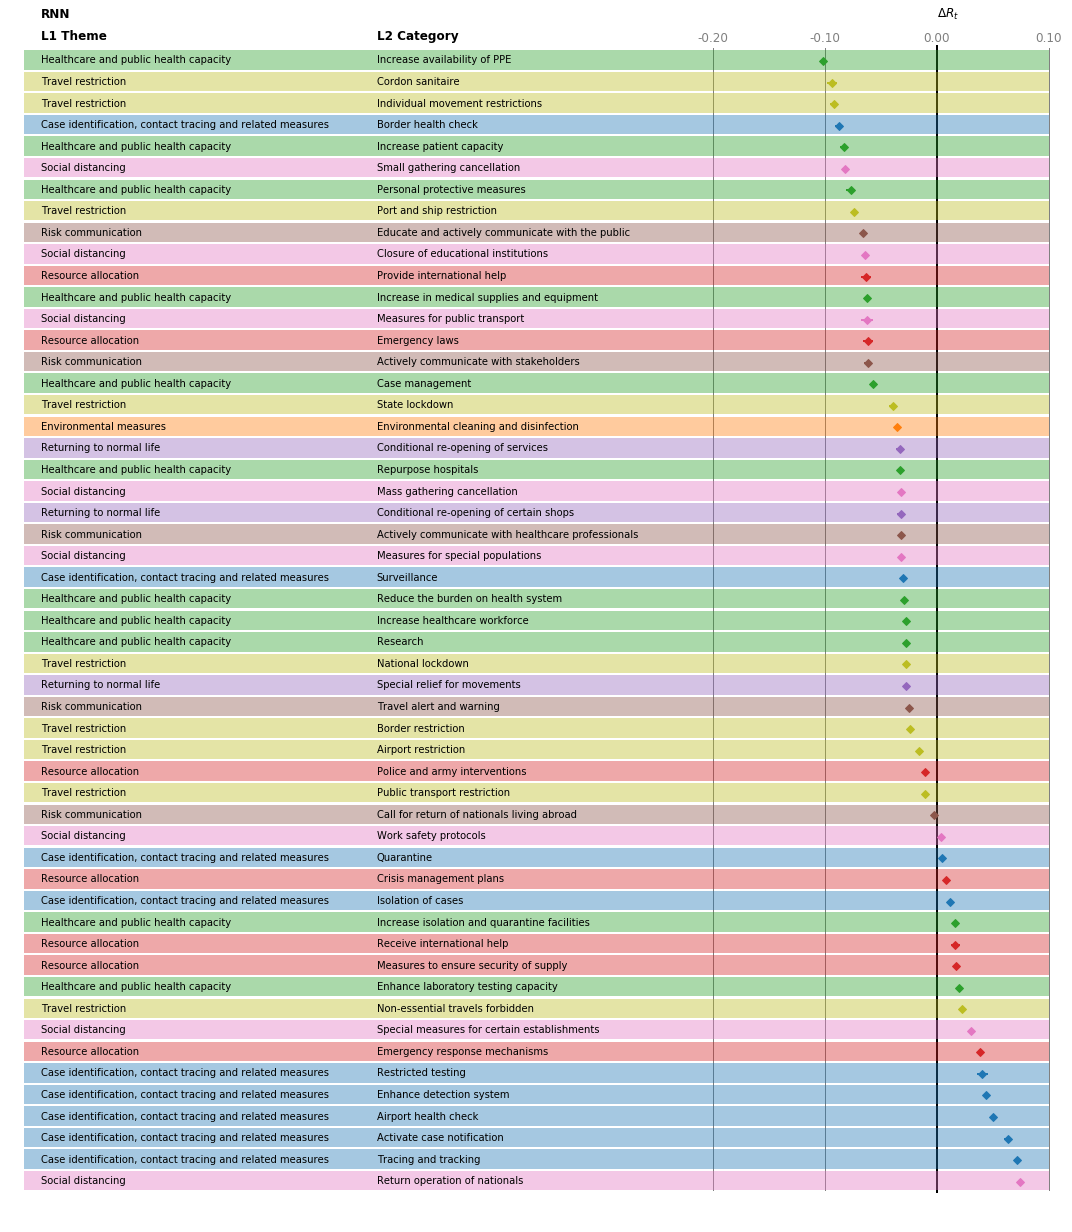

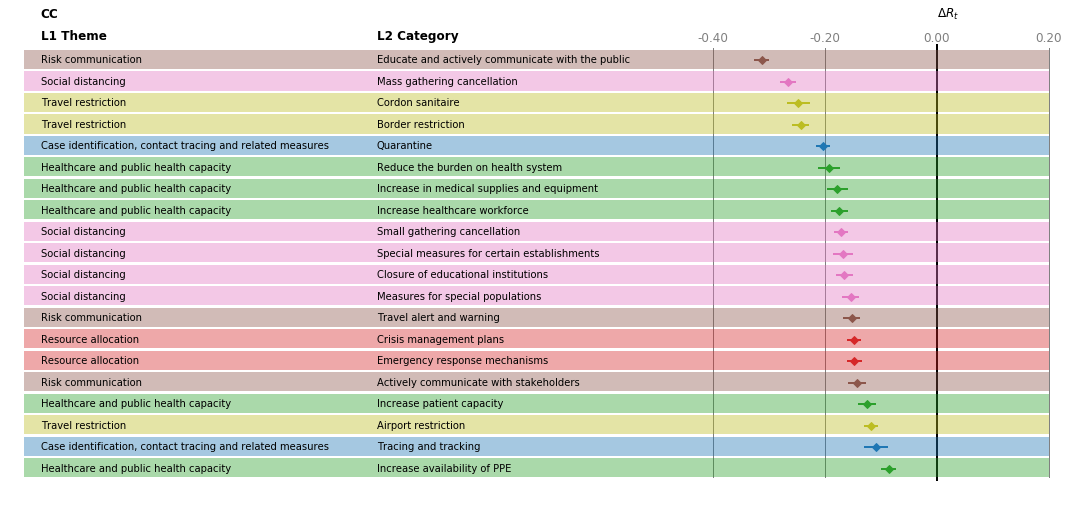

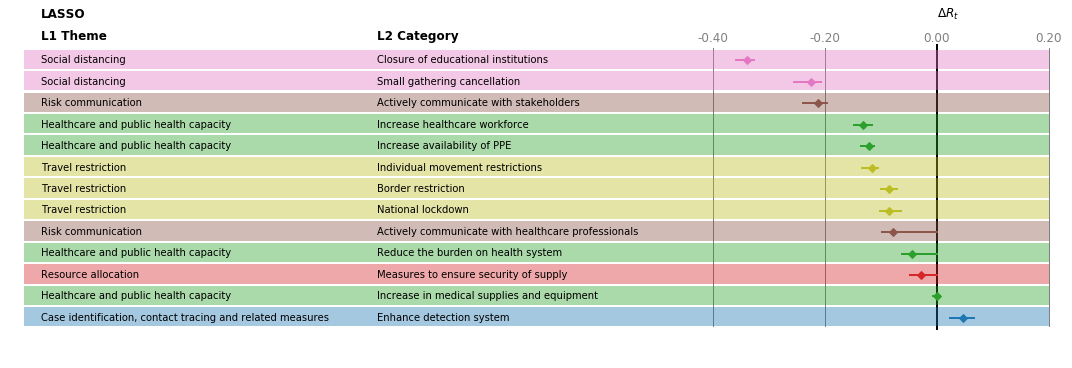

In [10]:
drop_zeros = True
measure_effects = {}
sort_order = {'RF':False,'CC':True,'RNN':True,'LASSO':True,'SCORE':False}
textbreak = 60
plot_keys = {}
for method in sort_order.keys():
    plot_keys[method] = ['{}_DeltaR'.format(method),'{}_low'.format(method),'{}_high'.format(method)]

PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['SCORE'], sort_ascending = sort_order['SCORE'], entryheight=.3, title = '', filename = 'measurelist_final_SCORES.pdf', textbreak = textbreak, graylines = [20,40,60,80], blacklines = [0,100], labelsize = 100, border = 5, observable = 'Normalized Score')
PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['RF'],    sort_ascending = sort_order['RF'],    entryheight=.3, title = 'RF',    filename = 'measurelist_final_RF.pdf',     textbreak = textbreak, graylines = [1,2,3,4],    labelsize = 4,  border = .2, observable = 'Importance')
PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['RNN'],   sort_ascending = sort_order['RNN'],   entryheight=.3, title = 'RNN',   filename = 'measurelist_final_RNN.pdf',    textbreak = textbreak, graylines = [-10,-20,10], labelsize = 30, border = 1.5)
PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['CC'],    sort_ascending = sort_order['CC'],    entryheight=.3, title = 'CC',    filename = 'measurelist_final_CC.pdf',     textbreak = textbreak, graylines = [-40,-20,20], labelsize = 60, border = 3)
PlotMeasureListSorted(measure_effects = mainresults, plot_keys = plot_keys['LASSO'], sort_ascending = sort_order['LASSO'], entryheight=.3, title = 'LASSO', filename = 'measurelist_final_LASSO.pdf',  textbreak = textbreak, graylines = [-40,-20,20], labelsize = 60, border = 3)



In [32]:
boxalpha = .4
plot_lines = {'CC':{'gray':[-.40,-.20,.20],'black':[0]},'LASSO' : {'gray':[-.40,-.20,.20],'black':[0]},'RF':{'gray':[.01,.02,.03,.04],'black':[0]},'RNN':{'gray':[-.4,-.20,.20],'black':[0]}}


def SignificantMeasure(values,method):
    if values[method] > 0: return True
    return False


def ShowLines(ax, gray = [], black = [], xmin = 0, ymin = 0, ymax = 0, xscale = 1, xoffset = 0, ytext = 2):
    for x in black:
        ax.plot([xscale * x + xoffset - xmin,xscale * x + xoffset - xmin],[ymin,ymax], lw = 2, c = 'black',zorder = -2)
        ax.annotate('{:.2f}'.format(x),[xscale * x + xoffset - xmin, ytext],fontsize = 12, c = 'gray', ha = 'center', va = 'top', rotation = 90)
    for x in gray:
        ax.plot([xscale * x + xoffset - xmin, xscale * x + xoffset - xmin],[ymin, ymax], lw = 1, c = 'gray',zorder = -2)
        ax.annotate('{:.2f}'.format(x),[xscale*x + xoffset - xmin, ytext],fontsize = 12, c = 'gray', ha = 'center', va = 'top', rotation = 90)

        
def PlotData(ax, xscale = 1, xoffset = 0, yoffset = 0, minplot = 0, data_keys = ['median','low','high'], ypos = 1, values = None, textbreak = 40, background = True):
    if background:
        ax.plot(xscale * values[data_keys[0]] - minplot + xoffset,[ypos + yoffset], c = L1colors[values['L1 theme']], marker = 'D', zorder = 10)
        ax.plot([xscale * values[data_keys[1]] - minplot + xoffset,xscale * values[data_keys[2]] - minplot + xoffset],[ypos + yoffset,ypos + yoffset], c = L1colors[values['L1 theme']], lw = 2, zorder = 10)
        bgcolor = L1colors[values['L1 theme']]
    else:
        bgcolor = '#d3d7cf'
        
    background_data = plt.Rectangle([xoffset, ypos - .4], 1, .9, fill = True, fc = bgcolor, alpha = boxalpha, zorder = 10)
    ax.add_patch(background_data)

        
def PlotMeasureListCombined(measure_effects, plot_keys = {}, filename = 'measurelist_sorted.pdf', figsize = (15,32), labelsize = 150, blacklines = [0], graylines = [-40,-20,20],
                          border = .15, title = '', textbreak = 50, include_countries = False, rescale = True, entryheight = None):

    fig,ax = plt.subplots(figsize = figsize)
    plot_height = len(measure_effects)
    
    allmethods = list(plot_keys.keys())
    allmethods.sort()
    
    for j,(index,values) in enumerate(measure_effects.iterrows()):
        background_text = plt.Rectangle([-3 - border, -j - .4], 3, .9, fill = True, fc = L1colors[values['L1 theme']], alpha = boxalpha, zorder = 1)
        ax.annotate(textwrap.shorten(str(values['L2 category']), width = textbreak), [-3, -j - .1], ha = 'left', zorder = 20)
        ax.add_patch(background_text)
        
        for m,method in enumerate(allmethods):
            all_lines = np.concatenate([plot_lines[method]['gray'], plot_lines[method]['black']])
            xscale    = 1/(np.max(all_lines) - np.min(all_lines))
            minplot   = np.min(all_lines) * xscale
            xoffset   = m * (1 + border)
            
            show_background = SignificantMeasure(values,method)
            
            PlotData(ax, data_keys=plot_keys[method], ypos = -j,values = values, textbreak = textbreak, xscale = xscale, xoffset = xoffset, background = show_background, minplot = minplot)
            if j == 0:
                ax.annotate(method, [xoffset,2.8],weight = 'bold',fontsize = 12)
                ShowLines(ax, gray = plot_lines[method]['gray'], black = plot_lines[method]['black'], xscale = xscale, xoffset = xoffset, ymin = -plot_height + .5, ymax = .6, xmin = minplot)

    legend_width = (7 + 4*border)/2 - border
    if 'Country Effects' in L1colors:
        del L1colors['Country Effects']
    ax.annotate('L1 Themes',[-border-3,-plot_height-2],weight = 'bold')
    for i,(l1category, color) in enumerate(L1colors.items()):
        l1back = plt.Rectangle([-3-border + (i%2) * (legend_width + border),-plot_height - (i//2) -3-.4],legend_width,.9,fill=True,fc=color,alpha = boxalpha, zorder= 1)
        ax.add_patch(l1back)
        ax.annotate(l1category,[-3+ (i%2) * (legend_width + border) ,-plot_height - (i//2) -3], color = color, weight = 'bold', zorder = 10, fontsize = 10)
    
    ax.set_ylim([-plot_height - len(L1colors) - 3,3])
    ax.axis('off')
    fig.savefig(filename, bbox_inches='tight')



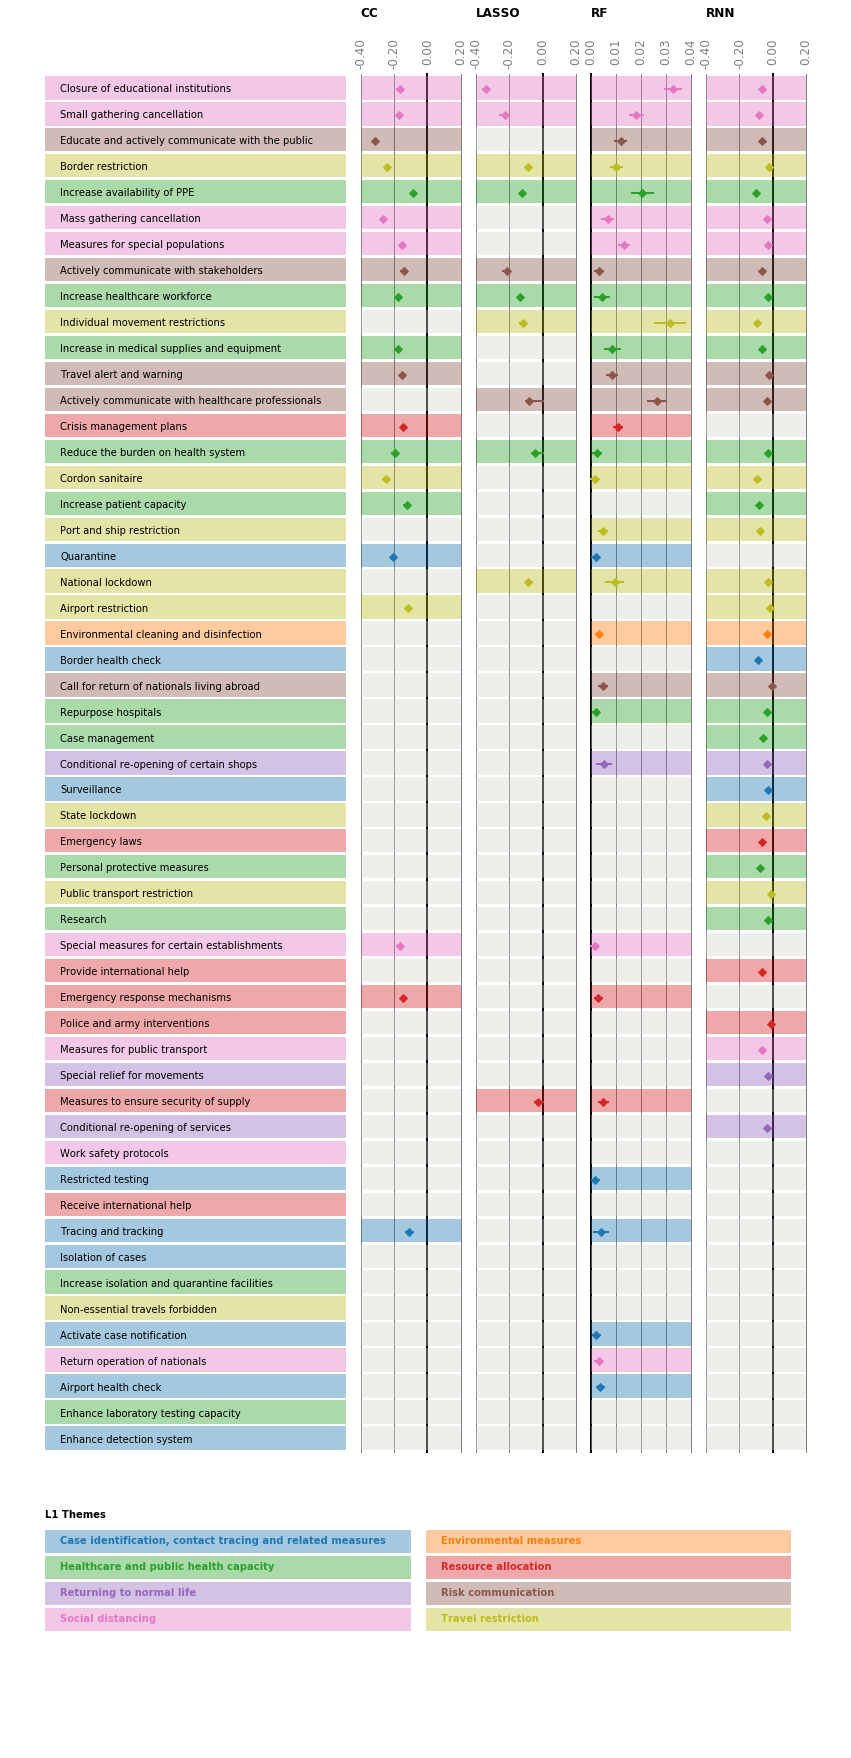

In [33]:
if 'SCORE' in plot_keys.keys():
    del plot_keys['SCORE']
mainresults_sortscore = mainresults.sort_values(by = 'SCORE_DeltaR', ascending = False)
PlotMeasureListCombined(mainresults_sortscore, plot_keys, filename='measurelist_final_combined.pdf')